In [2]:
# DRO actual data 

In [3]:
IN_COLAB = False
REMOUNT = False

In [4]:
# RUN IN COLAB ONLY: mount Google drive
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

In [5]:
# RUN IN COLAB ONLY: unmount, remount Google drive - if required
if REMOUNT:
    !fusermount -u /content/drive 2>/dev/null || true
    !rm -rf /content/drive
    from google.colab import auth
    auth.authenticate_user()
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

In [6]:
# RUN IN COLAB ONLY: install required modules: ssm, openpyxl
if IN_COLAB:
    !pip -q install git+https://github.com/lindermanlab/ssm.git #egg=ssm
    !pip -q install openpyxl
    !pip -q install filelock pyarrow

In [7]:
# RUN IN COLAB ONLY: force-fetch latest files from GitHub (overwrite local copies)
if IN_COLAB:
    !rm -rf /content/SLDS
    !git clone --depth=1 https://github.com/chrismader1/SLDS.git /content/SLDS
    import sys
    sys.path.append("/content/SLDS")

In [8]:
# RUN IN COLAB ONLY: prevent timeouts
if IN_COLAB:
    from IPython.display import Javascript, display
    display(Javascript("""
    (function keepAlive(){
      function clickConnect(){
        // Try shadow-root button (newer Colab)
        const el = document.querySelector('colab-connect-button');
        if (el && el.shadowRoot){
          const btn = el.shadowRoot.querySelector('#connect');
          if (btn){ btn.click(); console.log('keepAlive: clicked shadow connect'); return; }
        }
        // Fallbacks
        const btn2 = document.querySelector('#connect, button#connect');
        if (btn2){ btn2.click(); console.log('keepAlive: clicked #connect'); return; }
        console.log('keepAlive: connect button not found');
      }
      setInterval(clickConnect, 60 * 1000);
      console.log('keepAlive: armed');
    })();
    """))

In [9]:
# RUN IN COLAB ONLY: clear cache
if IN_COLAB:
    !rm -f "/content/drive/MyDrive/Colab Notebooks/SLDS/Data/gridsearch_results.csv"
    !rm -f "/content/drive/MyDrive/Colab Notebooks/SLDS/Data/gridsearch_segments.csv"
    !echo "Reset done."

In [10]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import itertools, warnings, os
from dro import *

import warnings
warnings.filterwarnings("ignore", message=r"Argument (sub|subj) .* Incorrect array format causing data to be copied")
pd.set_option('future.no_silent_downcasting', True)

In [11]:
# paths

COLAB_PATHS = {
    "data_excel": "/content/drive/MyDrive/Colab Notebooks/SLDS/Data/bbg_data.xlsx",  # Google Drive
    "ff_dir": "/content/drive/MyDrive/Colab Notebooks/SLDS/Data/",                   # Google Drive
    "ff_files": {
        "ff5": "F-F_Research_Data_5_Factors_2x3_daily.csv",
        "ff3": "F-F_Research_Data_Factors_daily.csv",
        "mom": "F-F_Momentum_Factor_daily.csv",},
    "results_csv": "/content/drive/MyDrive/Colab Notebooks/SLDS/Out/gridsearch_results.csv",            # Google Drive
    "segments_parquet": "/content/drive/MyDrive/Colab Notebooks/SLDS/Out/gridsearch_segments.parquet",  # Google Drive
    "tmp_dir":          "/content/tmp_slds/",                      # Colab local
    "segments_tmp_csv": "/content/tmp_slds/segments_tmp.csv",      # Colab local
}

LOCAL_PATHS = {
    "data_excel": "/Users/chrismader/Python/SLDS/Data/bbg_data.xlsx",
    "ff_dir": "/Users/chrismader/Python/SLDS/Data/",
    "ff_files": {
        "ff5": "F-F_Research_Data_5_Factors_2x3_daily.csv",
        "ff3": "F-F_Research_Data_Factors_daily.csv",
        "mom": "F-F_Momentum_Factor_daily.csv",},
    "results_csv": "/Users/chrismader/Python/SLDS/Out/gridsearch_results.csv",
    "segments_parquet": "/Users/chrismader/Python/SLDS/Out/gridsearch_segments.parquet",
    "tmp_dir":          "/Users/chrismader/Python/SLDS/tmp_slds/",
    "segments_tmp_csv": "/Users/chrismader/Python/SLDS/tmp_slds/segments_tmp.csv",
}

In [12]:
# -------------------------
# CONFIG
# -------------------------

CONFIG = {
    
    # Core defaults
    "dt": 1.0 / 252.0,
    "n_iters": 10,
    "h_z": 10.0,  # CUSUM threshold

    # Batch windows
    "batch_grid": [
        # {"train_window": 504, "overlap_window": 63},
        {"train_window": 756, "overlap_window": 63},
        # {"train_window": 1260, "overlap_window": 63},
    ],

    # Number of regimes
    "K_grid": [3],
    # "K_grid": [2, 3],
    
    # Unrestricted models: 
    "unrestricted_models": [
        # {"label": "[y]",         "channels": ["y"],                "dim_latent": [1]},
        {"label": "[y,h]",       "channels": ["y","h"],            "dim_latent": [2]},
        # {"label": "[g,v]",       "channels": ["g","v"],            "dim_latent": [2]},
        # {"label": "[g,v,h]",     "channels": ["g","v","h"],        "dim_latent": [2,3]},
        # {"label": "[y,g,v,h]",   "channels": ["y","g","v","h"],    "dim_latent": [3,4]},
    ],

    # Restricted models: 
    "restricted_models": [
        # {"label": "fund1",        "channels": ["y"],                 "dim_latent": [2],    "C_type": "fund1"},
        # {"label": "fund1_vix",    "channels": ["y","h"],             "dim_latent": [3],    "C_type": "fund1_vix"},
        # {"label": "fund2",        "channels": ["y","g"],             "dim_latent": [2],    "C_type": "fund2"},
        # {"label": "fund2_vix",    "channels": ["y","g","h"],         "dim_latent": [3],    "C_type": "fund2_vix"},
        # {"label": "fund3",        "channels": ["y","v","g"],         "dim_latent": [2],    "C_type": "fund3"},
        # {"label": "fund3_vix",    "channels": ["y","v","g","h"],     "dim_latent": [3],    "C_type": "fund3_vix"},   

        # {"label": "factor1",      "channels": ["y"],                 "dim_latent": [2],    "C_type": "factor1"},
        # {"label": "factor1_vix",  "channels": ["y","h"],             "dim_latent": [3],    "C_type": "factor1_vix"},

        {"label": "factor2_ff3",   "channels": ["y","mkt","smb","hml"],                   "dim_latent": [3], "C_type": "factor2"},
        # {"label": "factor2_ff3mom","channels": ["y","mkt","smb","hml","mom"],             "dim_latent": [4], "C_type": "factor2"},
        # {"label": "factor2_ff5",   "channels": ["y","mkt","smb","hml","rmw","cma"],       "dim_latent": [5], "C_type": "factor2"},
        # {"label": "factor2_ff5mom","channels": ["y","mkt","smb","hml","rmw","cma","mom"], "dim_latent": [6], "C_type": "factor2"},
    ],

    # Model selection
    "run_unrestricted": True,
    "run_restricted": True,

    # Output
    "verbose": False,
    "display": False,
    "predict_oos": True,
}

PATHS = COLAB_PATHS if IN_COLAB else LOCAL_PATHS
for k, v in PATHS.items(): 
    CONFIG[k] = v
# per-security temp file templates used by IOManager
CONFIG["tmp_results_fmt"]  = "{tmp_dir}/tmp_res_{security}.csv"
CONFIG["tmp_segments_fmt"] = "{tmp_dir}/tmp_seg_{security}.csv"


DRO_CONFIG = {

    # Controls
    "run_gridsearch": False,

    # Optimizer
    "start_dt": None,
    "end_dt": None,
    "min_assets": 3,
    "GLOBAL": {"risk_budget": 0.30, "risk_free_rate": 0.0, "epsilon_sigma": 1e-6,},
    "delta_name": "kappa_l2",
}

DELTA_DEFAULTS = {
    "kappa_l2": {"delta_method": "kappa_l2", "kappa": 1.0},
    "kappa_rate": {"delta_method": "kappa_rate", "kappa": 1.0},
    "bound_ek": {"delta_method": "bound_ek", "alpha": 0.05, "c1": 3.0, "c2": 1.0, "a": 2.0},
    "bootstrap_np": {"delta_method": "bootstrap_np", "alpha": 0.05, "B": 100, "seed": 0},
    "bootstrap_gaussian": {"delta_method": "bootstrap_gaussian", "alpha": 0.05, "B": 100, "seed": 0},
}


In [13]:
# -------------------------
# Execute
# -------------------------

if __name__ == "__main__":
    securities = ['MSFT', 'NVDA', 'AAPL']
    out = dro_pipeline(securities, CONFIG, DRO_CONFIG, DELTA_DEFAULTS)


run_gridsearch=False → using tickers in gridsearch_results

[MSFT] raw segments: [0, 786, 1564, 1589, 1590, 1591, 1603, 1623, 1624, 1625, 1645, 1767, 1768, 1769, 1819, 1823, 1824, 1832, 1884, 1891, 1920, 1933, 1936, 1941, 1980, 1981, 1986, 2009, 2022, 2033, 2109, 2118, 2125, 2130, 2138, 2139, 2145, 2146, 2152, 2153, 2156, 2157, 2166, 2167, 2259, 2263, 2335, 3459, 3461, 3521]
[NVDA] raw segments: [0, 786, 1563, 1590, 1591, 1593, 1594, 1597, 1602, 1625, 1638, 1642, 1768, 1769, 1771, 1776, 1777, 1778, 1784, 1790, 1793, 1794, 1796, 1800, 1801, 1802, 1805, 1806, 1812, 1815, 1820, 1828, 1829, 1830, 1834, 1887, 1889, 1922, 1923, 1926, 1936, 1941, 1980, 1982, 1991, 1994, 1996, 1998, 2002, 2025, 2032, 2125, 2127, 2130, 2134, 2136, 2138, 2139, 2145, 2146, 2147, 2149, 2152, 2153, 2157, 2162, 2164, 2166, 2167, 2170, 2173, 2174, 2184, 2185, 2186, 2193, 2197, 2201, 2202, 2204, 2209, 2212, 2215, 2222, 2252, 2267, 2272, 2277, 2282, 2287, 2291, 2302, 2305, 2307, 2314, 2319, 2331, 2341, 3120, 3459, 3461

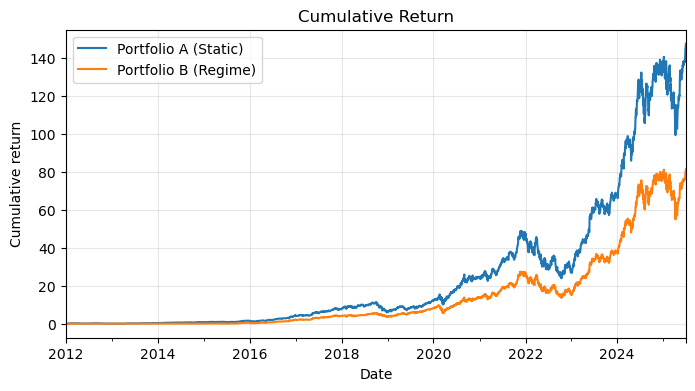

In [14]:
# Plot Portfolio A vs Portfolio B

import pandas as pd
import matplotlib.pyplot as plt

# pull series safely
sA = pd.Series(out["series"].get("PartA_daily", pd.Series(dtype=float))).sort_index()
sB = pd.Series(out["series"].get("PartB_daily", pd.Series(dtype=float))).sort_index()

if sA.empty or sB.empty:
    raise ValueError("Missing series in `out['series']`. Expected 'PartA_daily' and 'PartB_daily'.")

# cumulative returns
cumA = (1 + sA).cumprod() - 1
cumB = (1 + sB).cumprod() - 1

# --- cumulative on one chart ---
fig, ax = plt.subplots(figsize=(8, 4))
cumA.plot(ax=ax, label="Portfolio A (Static)")
cumB.plot(ax=ax, label="Portfolio B (Regime)")
ax.set_title("Cumulative Return")
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative return")
ax.grid(True, alpha=0.3)
ax.legend()